# Loan predictions
## `Manual Data Preprocessing and Modeling`

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import warnings 
warnings.filterwarnings('ignore')
sns.set()
%matplotlib inline

In [6]:
df = pd.read_csv("data/data.csv") 
print(df.shape)
df.head()

(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Data Cleaning

This step typically involves imputing missing values and treating outliers. 

### Imputing Missing Values

Missing values may not always be NaNs. For instance, the `Loan_Amount_Term` might be 0, which does not make sense.



In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Impute missing values for all columns. Use the values which you find most meaningful (mean, mode, median, zero.... maybe different mean values for different groups)

In [8]:
# Get an overview of the missing data
count_missing = df.isnull().sum().sort_values(ascending=False)
percent_missing = (df.isnull().sum()/df.isnull().count())
data_missing = pd.concat([count_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
data_missing

,Total,Percent
Credit_History,50,0.081433
Self_Employed,32,0.052117
LoanAmount,22,0.035831
Dependents,15,0.024430
Loan_Amount_Term,14,0.022801
Gender,13,0.021173
Married,3,0.004886
Loan_ID,0,0.000000
Education,0,0.000000
ApplicantIncome,0,0.000000


In [9]:
# Fill with most common value
df['Gender'] = df['Gender'].fillna('Male')

In [10]:
## No other better option than filling with No or zero for the following columns
df['Married'] = df['Married'].fillna('No')
df['Self_Employed'] = df['Self_Employed'].fillna('No')
df['Credit_History'] = df['Credit_History'].fillna(0)
df['Dependents'] = df['Dependents'].fillna(0)

In [11]:
# Fill 3+ dependents with 4, as values bigger than 4 are most probably rare and outliers
df['Dependents'] = df['Dependents'].replace('3+',4)

In [12]:
# Fill with average
df['LoanAmount'] = df['LoanAmount'].fillna((df['LoanAmount'].mean()))

In [13]:
df['Loan_Amount_Term'].mode()

0    360.0
dtype: float64

In [14]:
## Given that this is a time value, fill with the most frequent value (which is 360)
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(360)

In [16]:
df.isna().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

### Extreme values
Try a log transformation to get rid of the extreme values in `LoanAmount`. Plot the histogram before and after the transformation

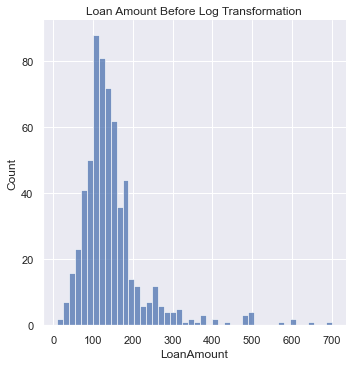

In [17]:
## Visualize and check for outliers
sns.displot(df.LoanAmount).set(title='Loan Amount Before Log Transformation');

In [18]:
# Apply log transformation to get rid of outliers
df.LoanAmount = np.log(df.LoanAmount)

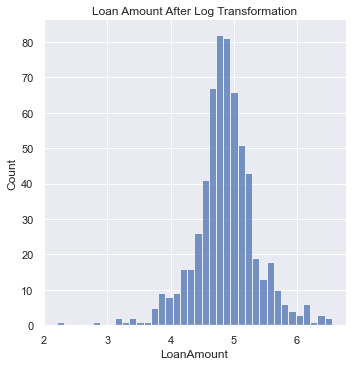

In [19]:
sns.displot(df.LoanAmount).set(title='Loan Amount After Log Transformation');

Combine both incomes as total income and take a log transformation of the same.

In [20]:
df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']

In [21]:
## Remove outliers from total income using log transform
df.Total_Income = np.log(df.Total_Income)

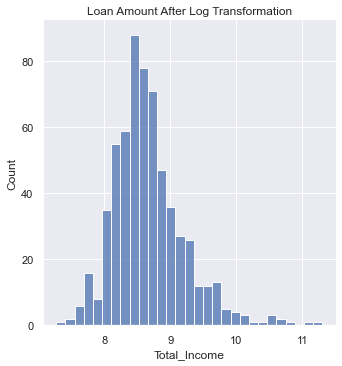

In [22]:
sns.displot(df.Total_Income).set(title='Loan Amount After Log Transformation');

## 4. Building a Predictive Model

In [26]:
# label encode the categorical variables (assign them dummy numeric values)
le = LabelEncoder()

df['Gender'] = le.fit_transform(df['Gender'])
df['Married'] = le.fit_transform(df['Married'])
df['Education'] = le.fit_transform(df['Education'])
df['Self_Employed'] = le.fit_transform(df['Self_Employed'])
df['Property_Area'] = le.fit_transform(df['Property_Area'])
df['Loan_Status'] = le.fit_transform(df['Loan_Status'])
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,LP001002,1,0,0,0,0,5849.0,0.0,4.986426,360.0,1.0,2,1,8.674026
1,LP001003,1,1,1,0,0,4583.0,1508.0,4.852030,360.0,1.0,0,0,8.714568
2,LP001005,1,1,0,0,1,3000.0,0.0,4.189655,360.0,1.0,2,1,8.006368
3,LP001006,1,1,0,1,0,2583.0,2358.0,4.787492,360.0,1.0,2,1,8.505323
4,LP001008,1,0,0,0,0,6000.0,0.0,4.948760,360.0,1.0,2,1,8.699515


In [104]:
## Define Features X and Target Variable y
# Drop Loan_ID as it is not needed
# Total Income is used instead of individual incomes

X = df.drop(columns=["Loan_Status", 'Loan_ID', 'ApplicantIncome', 'CoapplicantIncome'])
y = df["Loan_Status"]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)


## Random Forest Classifier

In [105]:
rf = RandomForestClassifier(max_depth=2, random_state=42)
rf.fit(X, y)

RandomForestClassifier(max_depth=2, random_state=42)

In [106]:
y_pred = rf.predict(X_test)

In [107]:
rf.score(X_test,y_test)

0.7532467532467533

Try paramater grid search to improve the results

In [110]:
# Create the parameter grid based on the results of random search 
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
# Create a based model
rf = RandomForestClassifier(random_state=42)
# Instantiate the grid search model
rf_gsearch = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2).fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200; total time=   0.9s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200; total time=   0.9s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200; total time=   0.9s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200; total time=   0.8s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500; total time=   2.0s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200; total time=   0.9s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500; total time=   2.1s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500; total time=   2.1s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200; total time=   0.8s
[CV] END criterion=gini, max_depth=4, max_features=log2, n_estimators=200; total time=   0.7

In [112]:
print('Score after Model Tuning: ', rf_gsearch.score(X_test, y_test))

Score after Model Tuning:  0.7727272727272727


In [113]:
best = rf_gsearch.best_params_
best

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 500}

## Try Logistic Regression

In [94]:
clf = LogisticRegression()
clf.fit(X_train,y_train)

LogisticRegression()

In [95]:
y_pred = clf.predict(X_test)


In [96]:
clf.score(X_test,y_test)

0.7597402597402597

Try paramater grid search to improve the results

In [83]:
# Guide here: https://towardsdatascience.com/logistic-clfression-model-tuning-with-scikit-learn-part-1-425142e01af5
param_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20)
}

In [99]:
clf_gsearch = GridSearchCV(clf, param_grid, cv =5, verbose=1).fit(X_train, y_train)

print('Score after Model Tuning: ', clf_gsearch.score(X_test, y_test))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Score after Model Tuning:  0.7597402597402597


In [100]:
best = clf_gsearch.best_params_
best

{'C': 11.288378916846883, 'penalty': 'l2'}